In [31]:
from models.regex import RegexModel
from data_loader import AnnotaionDataLoader
from model_evaluation import ModelEvalWrapper, ModelEvaluator, ModelEvalWrapperInterface

regex_m = RegexModel()
dataloader = AnnotaionDataLoader()
# regex_m.predict(["Unknown function", " ", "Not known", "no data", "\n"])



In [4]:
psutil.Process()

psutil.Process(pid=12508, name='python.exe', status='running', started='21:51:14')

In [ ]:
import psutil
import threading
import time
import matplotlib.pyplot as plt

def monitor_memory(interval=0.01):
    """Continuously record memory usage of the current process."""

    # select current process
    process = psutil.Process()
    
    memory_records = {}
    start_time = time.time()
    # add a record for the memory at time t=0
    memory_records[0] = process.memory_info().rss

    def record():
        while not stop_event.is_set():
            mem = process.memory_info().rss # in bytes
            current_timestamp = time.time() - start_time # timestamp is the time delta
            memory_records[current_timestamp] = mem
            time.sleep(interval)

    stop_event = threading.Event()
    monitor_thread = threading.Thread(target=record)
    monitor_thread.start()
    return stop_event, memory_records

def track_model_prediction(model, X, interval=0.01):
    stop_event, memory_records = monitor_memory(interval)
    
    X_train = dataloader.get_train()["X"]
    preds = regex_m.predict(X_train)

    # Stop monitoring
    stop_event.set()

    return preds, memory_records

a, b, c =track_model_prediction("A" ,"a")

# # Compute stats
# avg_mem = sum(mem_usage) / len(mem_usage)
# peak_mem = max(mem_usage)
# print(f"Average memory usage: {avg_mem:.2f} MB")
# print(f"Peak memory usage: {peak_mem:.2f} MB")
# print(f"Prediction time: {end_time - start_time:.4f} sec")

# # Plot memory over time
# plt.figure(figsize=(10, 5))
# plt.plot(timestamps, mem_usage, label="Memory Usage (bytes)")
# plt.xlabel("Time (s)")
# plt.ylabel("Memory (MB)")
# plt.title("Memory Usage During Prediction")
# plt.legend()
# plt.grid(True)
# plt.show()


In [35]:
b

{0.010004281997680664: 192995328,
 0.022980690002441406: 196591616,
 0.05556130409240723: 195764224,
 0.07355213165283203: 195768320,
 0.10474658012390137: 195768320,
 0.14075183868408203: 195768320,
 0.2042558193206787: 195768320,
 0.24625396728515625: 195784704,
 0.27146077156066895: 195784704,
 0.28901195526123047: 195784704,
 0.3549313545227051: 195784704}

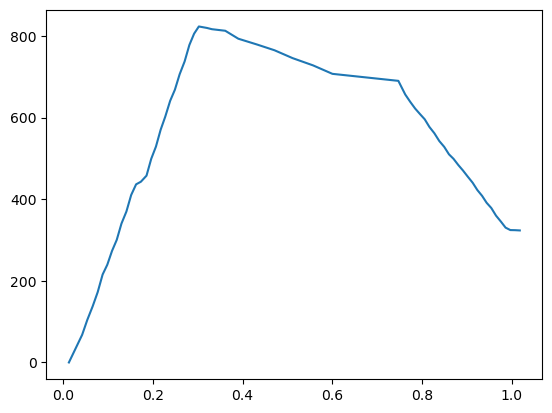

In [27]:
plt.plot(c,[(x -d)/((1024 * 1024)) for x in b], label="Memory Usage (bytes)")


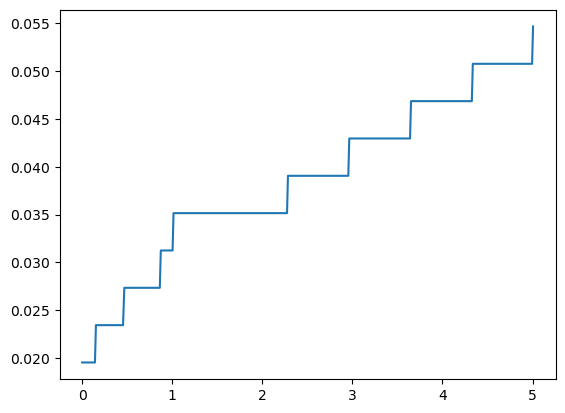

In [19]:
plt.plot(c,[(x -d)/((1024 * 1024)) for x in b], label="Memory Usage (bytes)")


#####	 Report for Model: fregex	

              precision    recall  f1-score   support

           0       1.00      0.45      0.62        87
           1       1.00      0.82      0.90        39
           2       0.94      1.00      0.97       874

    accuracy                           0.94      1000
   macro avg       0.98      0.76      0.83      1000
weighted avg       0.95      0.94      0.94      1000

The model took 0.07658 seconds to run

Average time per prediction 0.00008



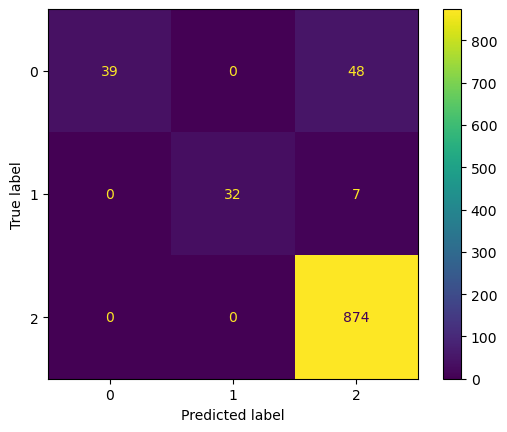

In [ ]:
## Evalute model
regex_m_wrapper = ModelEvalWrapper(regex_m, "regex")
m = ModelEvaluator(regex_m_wrapper, dataloader.get_validation())

c_report = m.generate_report()
c_report.show_report()
